# Tensor Flow

In [2]:
import tensorflow as tf
from tensorflow.keras import layers,models
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Button
import pickle
import matplotlib.patches as patches

%matplotlib widget

## Model

In [43]:
model = models.Sequential()
model.add(layers.Conv2D(32, (5,5), activation='relu', input_shape=(256,256,3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32, (3,3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.35))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dropout(0.35))
model.add(layers.Dense(4))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 252, 252, 32)      2432      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 126, 126, 32)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 124, 124, 32)      9248      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 60, 60, 32)        9248      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 30, 30, 32)      

In [44]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.MeanSquaredError(),)

## Import data

In [4]:
with open('labeled_data/sources_0.obj', 'rb') as f:
    sources = pickle.load(f)

### Only original sources

In [9]:
filenames = os.listdir('labeled_data')

sources = []

for filename in filenames:
    if filename.startswith('sources'):
        print(filename)
        with open('labeled_data/' + filename, 'rb') as f:
            data = pickle.load(f)
            sources.extend(data)

sources_0.obj
sources_1.obj
sources_2.obj
sources_3.obj
sources_4.obj
sources_5.obj
sources_6.obj


In [13]:
print(len(sources))

700


### Import all sources

In [33]:
filenames = os.listdir('labeled_data')

sources = []

for filename in filenames:
    with open('labeled_data/' + filename, 'rb') as f:
        data = pickle.load(f)
        sources.extend(data)

In [34]:
print(len(sources))

2800


First time I tried 80 as the training size, that seemed to work well, but I haven't been able to replicate that early success...

In [35]:
trainingSize = 2600
testSize = len(sources)-1 - trainingSize

In [36]:
train_images = np.empty((trainingSize, 256, 256, 3), dtype=np.float32)
train_labels = np.empty((trainingSize, 4), dtype=np.float32)
test_images = np.empty((testSize, 256, 256, 3), dtype=np.float32)
test_labels = np.empty((testSize, 4), dtype=np.float32)

For some reason number 99 doesn't work, so I had to only take up to index 98...

In [37]:
randomIndices = np.random.choice(len(sources)-1, len(sources)-1,replace=False)

In [14]:
mySource = sources[randomIndices[0]]

In [15]:
(x0,x1) = (mySource.images[0].x0, mySource.images[0].x1)

In [17]:
np.array([x0,x1],dtype=np.float32)

array([  7., 256.], dtype=float32)

In [38]:
for i in range(trainingSize):
    source = sources[randomIndices[i]]
    images = np.dstack((source.images[0].data, source.images[1].data, source.images[2].data))
    (x0,x1) = (source.images[0].x0, source.images[0].x1)
    (y0,y1) = (source.images[0].y0, source.images[0].y1)
    labels = np.array([x0,x1,y0,y1])
    train_images[i] = images
    train_labels[i] = labels
for i in range(testSize):
    source = sources[randomIndices[i+trainingSize]]
    images = np.dstack((source.images[0].data, source.images[1].data, source.images[2].data))
    (x0,x1) = (source.images[0].x0, source.images[0].x1)
    (y0,y1) = (source.images[0].y0, source.images[0].y1)
    labels = np.array([x0,x1,y0,y1])
    test_images[i] = images
    test_labels[i] = labels

### Data exploration

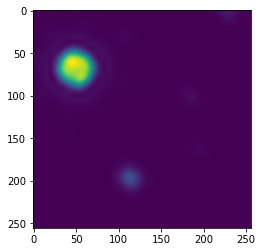

In [107]:
plt.imshow(train_images[0,:,:,2])

Need to get max values from each image set to scale values accordingly.

In [39]:
for band in range(3):
    ind = np.argpartition(train_images[:,:,:,band].flatten(), -10)[-10:]
    print('Band ', band, ': ', train_images[:,:,:,band].flatten()[ind])

Band  0 :  [0.2297528  0.2302746  0.2302746  0.23036858 0.2302746  0.23036858
 0.23036858 0.23060822 0.23060822 0.23060822]
Band  1 :  [75325.125 75396.33  75396.33  75735.82  75396.33  75735.82  75735.82
 75890.016 75890.016 75890.016]
Band  2 :  [172585.14 172768.6  172768.6  172867.1  172867.1  172768.6  172867.1
 172926.61 172926.61 172926.61]


Want to normalize all images.

* Band 0: divide by .15
* Band 1: divide by 70000
* Band 2: divide by 170000

After normalizing, model is much faster to train, going from loss of ~20000 -> 7000 in 50 epochs (leraning rate of 0.0002) as opposed to ~50000 -> 14000 pre-normalization. 70% used in training dataset, 30% in test.

In [108]:
train_images[:,:,:,0] = train_images[:,:,:,0]/.15
train_images[:,:,:,1] = train_images[:,:,:,1]/70000
train_images[:,:,:,2] = train_images[:,:,:,2]/170000
test_images[:,:,:,0] = test_images[:,:,:,0]/.15
test_images[:,:,:,1] = test_images[:,:,:,1]/70000
test_images[:,:,:,2] = test_images[:,:,:,2]/170000

In [109]:
for band in range(3):
    ind = np.argpartition(train_images[:,:,:,band].flatten(), -10)[-10:]
    print('Band ', band, ': ', train_images[:,:,:,band].flatten()[ind])

Band  0 :  [0.8252072 0.879567  0.9060138 0.9434604 0.9486606 0.9756886 0.8267954
 0.8866661 0.8559458 0.9185725]
Band  1 :  [0.9786003  0.97865695 0.9815876  0.98071337 0.9821288  0.9805606
 0.98088205 0.979774   0.9834706  0.9821801 ]
Band  2 :  [0.99540424 0.9956335  0.99635965 0.9967495  0.99908483 0.9997673
 0.9992371  0.9979563  0.9978025  0.99864477]


In [40]:
print("Train: ", train_images.shape)
print("Train Labels: ", train_labels.shape)
print("Test: ", test_images.shape)
print("Test Labels: ", test_labels.shape)

Train:  (2600, 256, 256, 3)
Train Labels:  (2600, 4)
Test:  (199, 256, 256, 3)
Test Labels:  (199, 4)


## Model Fitting/Training

Below is the normal fitting method.

In [45]:
history = model.fit(train_images, train_labels, epochs=100)

Epoch 1/100
82/82 [==============================] - 3s 33ms/step - loss: 48186.8164
Epoch 2/100
82/82 [==============================] - 3s 32ms/step - loss: 21118.2520
Epoch 3/100
82/82 [==============================] - 3s 33ms/step - loss: 20538.8535
Epoch 4/100
82/82 [==============================] - 3s 33ms/step - loss: 20377.1875
Epoch 5/100
82/82 [==============================] - 3s 33ms/step - loss: 19142.7715
Epoch 6/100
82/82 [==============================] - 3s 33ms/step - loss: 18451.8965
Epoch 7/100
82/82 [==============================] - 3s 33ms/step - loss: 17855.1797
Epoch 8/100
82/82 [==============================] - 3s 33ms/step - loss: 16711.5332
Epoch 9/100
82/82 [==============================] - 3s 33ms/step - loss: 16297.0127
Epoch 10/100
82/82 [==============================] - 3s 33ms/step - loss: 15226.9170
Epoch 11/100
82/82 [==============================] - 3s 33ms/step - loss: 14534.9443
Epoch 12/100
82/82 [==============================] - 3s 33ms/s

Not entirely sure if it's fine to have the validation data in here below

In [32]:
history = model.fit(train_images, train_labels, epochs=20, batch_size=12, validation_data=(test_images, test_labels))

Epoch 1/20
50/50 [==============================] - 6s 21ms/step - loss: 45066.0312 - val_loss: 20161.7090
Epoch 2/20
50/50 [==============================] - 1s 17ms/step - loss: 27396.6074 - val_loss: 19692.3691
Epoch 3/20
50/50 [==============================] - 1s 17ms/step - loss: 22639.4941 - val_loss: 19546.7012
Epoch 4/20
50/50 [==============================] - 1s 17ms/step - loss: 21140.6484 - val_loss: 19404.9668
Epoch 5/20
50/50 [==============================] - 1s 17ms/step - loss: 20795.9492 - val_loss: 19360.9355
Epoch 6/20
50/50 [==============================] - 1s 17ms/step - loss: 20040.3164 - val_loss: 19313.8594
Epoch 7/20
50/50 [==============================] - 1s 17ms/step - loss: 20215.5117 - val_loss: 19244.0488
Epoch 8/20
50/50 [==============================] - 1s 17ms/step - loss: 19843.4043 - val_loss: 19193.8086
Epoch 9/20
50/50 [==============================] - 1s 17ms/step - loss: 19669.0625 - val_loss: 19121.5898
Epoch 10/20
50/50 [==================

In [47]:
model.predict(test_images[0:10])

1/1 [==============================] - 1s 549ms/step


array([[100.90627 , 105.53724 , 107.30698 , 109.203835],
       [105.49029 , 110.59873 , 111.808876, 113.91418 ],
       [109.70659 , 117.164375, 119.53255 , 118.60903 ],
       [ 91.05926 ,  97.62376 , 100.49114 , 101.82711 ],
       [101.79141 , 107.401054, 109.48694 , 110.29832 ],
       [114.15512 , 120.11283 , 124.231064, 122.57255 ],
       [103.98909 , 109.352715, 110.332985, 113.07151 ],
       [ 92.35942 ,  88.15813 ,  87.419395,  99.20201 ],
       [110.29441 , 116.91765 , 120.713646, 120.68884 ],
       [ 89.636   ,  90.894745,  91.38652 ,  90.35579 ]], dtype=float32)

In [48]:
test_labels[0:10]

array([[150., 109., 107., 149.],
       [181., 144., 146., 111.],
       [ 99., 151., 106., 156.],
       [144.,  82., 150., 112.],
       [144., 113., 108., 144.],
       [112., 152., 114., 149.],
       [  0., 256.,   0., 256.],
       [ 82., 168., 167.,  81.],
       [144., 109., 151., 113.],
       [148.,  99., 107., 151.]], dtype=float32)

KeyError: 'val_loss'

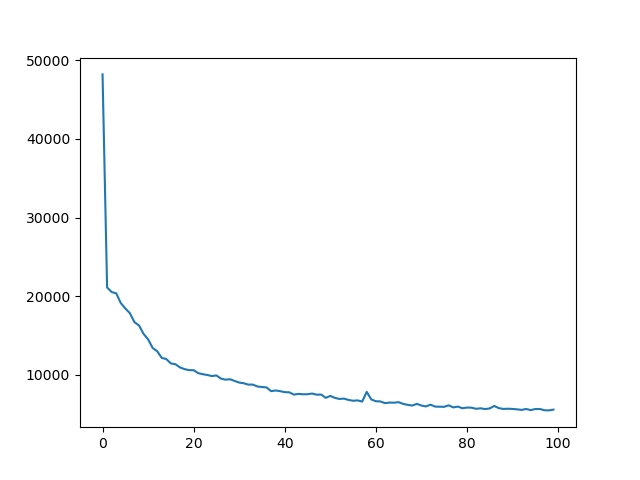

In [46]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [126]:
model.evaluate(test_images, test_labels)

1/1 [==============================] - 0s 288ms/step - loss: 34160.9492


34160.94921875

## Show predicted boxes

In [49]:
predict_labels = model.predict(test_images[0:10])

1/1 [==============================] - 0s 22ms/step


In [50]:
print(predict_labels)

[[100.90627  105.53724  107.30698  109.203835]
 [105.49029  110.59873  111.808876 113.91418 ]
 [109.70659  117.164375 119.53255  118.60903 ]
 [ 91.05926   97.62376  100.49114  101.82711 ]
 [101.79141  107.401054 109.48694  110.29832 ]
 [114.15512  120.11283  124.231064 122.57255 ]
 [103.98909  109.352715 110.332985 113.07151 ]
 [ 92.35942   88.15813   87.419395  99.20201 ]
 [110.29441  116.91765  120.713646 120.68884 ]
 [ 89.636     90.894745  91.38652   90.35579 ]]


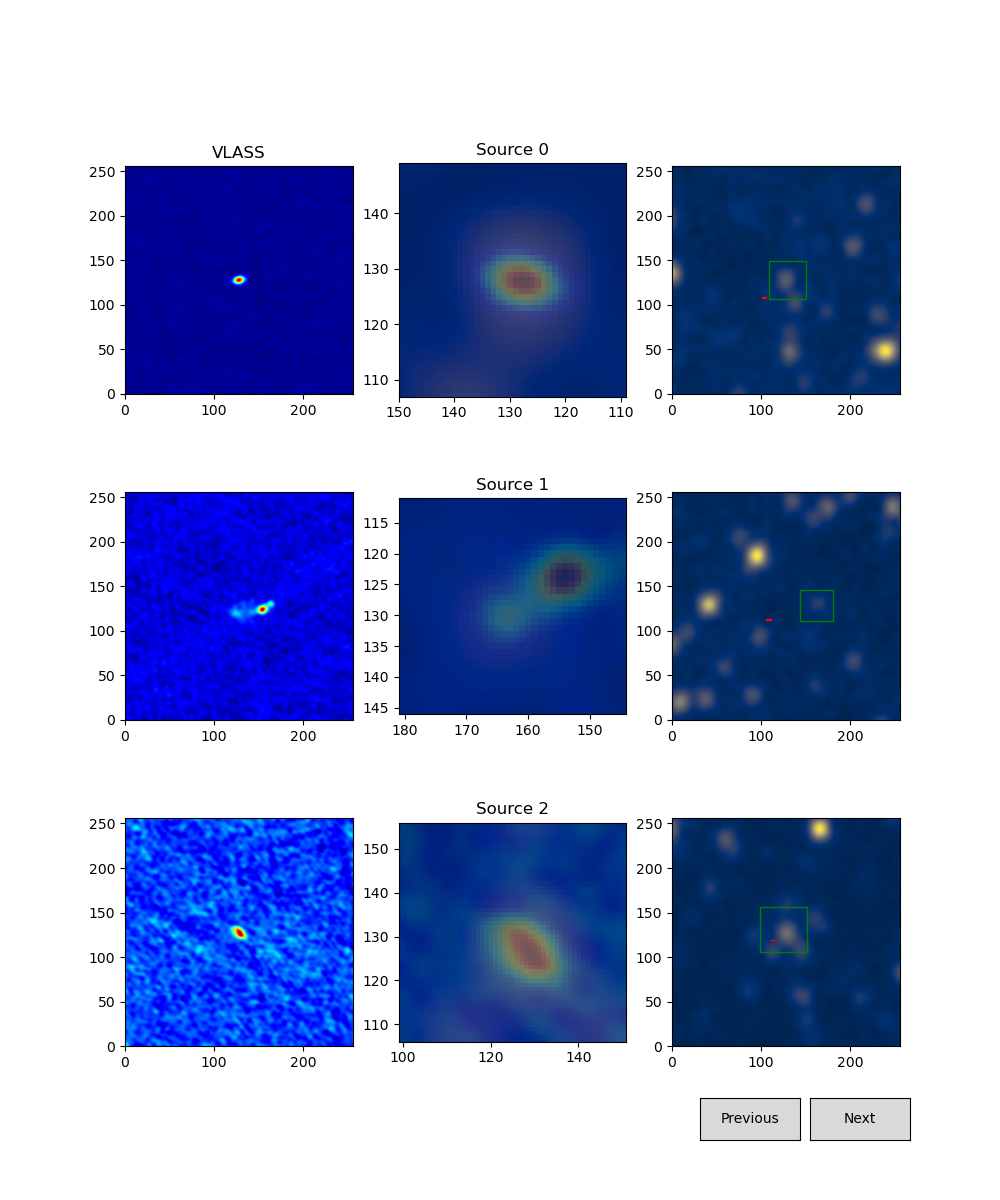

IndexError: index 10 is out of bounds for axis 0 with size 10

In [51]:
plt.close()

sourceLength = len(test_images)
nSources = 3

fig, ax = plt.subplots(nSources, 3, figsize=(10, 12))
ax[0][0].set_title('VLASS')
ax[0][1].set_title('VLASS + WISE')
ax[0][2].set_title('WISE')

class Index:
    ind = 0

    def next(self, event):
        self.ind += nSources
        i = self.ind % sourceLength
        self.showFigures()
        plt.draw()

    def prev(self, event):
        self.ind -= nSources
        i = self.ind % sourceLength
        self.showFigures()
        plt.draw()

    def showFigures(self):
        for i in range(nSources):
            (px0,px1,py0,py1) = predict_labels[self.ind+i]
            (x0,x1,y0,y1) = test_labels[self.ind+i]
            ax[i][0].imshow(test_images[i+self.ind,:,:,0], origin='lower', cmap='jet')
            ax[i][0].set_xlim(0, 256); ax[i][0].set_ylim(0, 256)

            ax[i][1].title.set_text('Source '+str(i+self.ind))
            ax[i][1].imshow(test_images[i+self.ind,:,:,1], origin='lower', cmap='cividis')
            ax[i][1].imshow(test_images[i+self.ind,:,:,0], origin='lower', cmap='jet', alpha=0.2)
            ax[i][1].set_xlim(x0, x1)
            ax[i][1].set_ylim(y0, y1)

            ax[i][2].cla()
            ax[i][2].imshow(test_images[i+self.ind,:,:,1], origin='lower', cmap='cividis')
            ax[i][2].set_xlim(0, 256); ax[i][2].set_ylim(0, 256)
            
            # Create a Rectangle patch
            rect = patches.Rectangle((px0, py0), px1-px0, py1-py0, linewidth=1, edgecolor='r', facecolor='none')
            # Labeled rectangle
            rect2 = patches.Rectangle((x0, y0), x1-x0, y1-y0, linewidth=1, edgecolor='g', facecolor='none')

            # Add the patch to the final image
            ax[i][2].add_patch(rect)
            ax[i][2].add_patch(rect2)

callback = Index()
callback.showFigures()
axprev = fig.add_axes([0.7, 0.05, 0.1, 0.035])
axnext = fig.add_axes([0.81, 0.05, 0.1, 0.035])
bnext = Button(axnext, 'Next')
bnext.on_clicked(callback.next)
bprev = Button(axprev, 'Previous')
bprev.on_clicked(callback.prev)

plt.show()

In [22]:
test_images.shape

(29, 256, 256, 3)